In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")

print("Path to dataset files:", path)

c:\Users\admin\anaconda3\envs\ustaad2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1


In [3]:
# Print out what's in the dataset path
for root, dirs, files in os.walk(path):
    print(f"📁 Folder: {root}")
    for f in files[:5]:
        print("  ┗", f)
    print()

📁 Folder: C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1

📁 Folder: C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1\Crema
  ┗ 1001_DFA_ANG_XX.wav
  ┗ 1001_DFA_DIS_XX.wav
  ┗ 1001_DFA_FEA_XX.wav
  ┗ 1001_DFA_HAP_XX.wav
  ┗ 1001_DFA_NEU_XX.wav

📁 Folder: C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1\Ravdess

📁 Folder: C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1\Ravdess\audio_speech_actors_01-24

📁 Folder: C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1\Ravdess\audio_speech_actors_01-24\Actor_01
  ┗ 03-01-01-01-01-01-01.wav
  ┗ 03-01-01-01-01-02-01.wav
  ┗ 03-01-01-01-02-01-01.wav
  ┗ 03-01-01-01-02-02-01.wav
  ┗ 03-01-02-01-01-01-01.wav

📁 Folder: C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1\Ravdess\audio_s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 169, 64)           12864     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 84, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 40, 128)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0

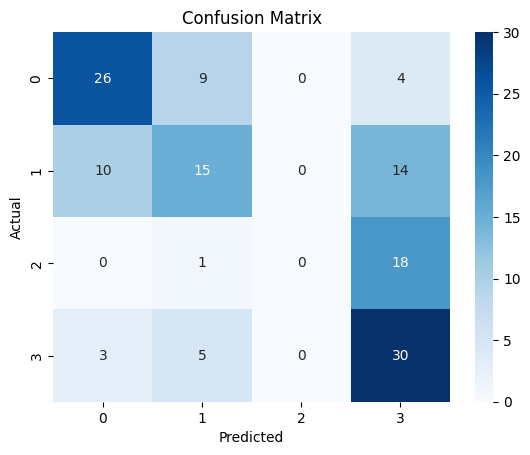

In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Update this path to where your RAVDESS files are
base_path = r"C:\Users\admin\.cache\kagglehub\datasets\dmitrybabko\speech-emotion-recognition-en\versions\1\Ravdess\audio_speech_actors_01-24"

# Emotion labels based on filename
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Filter these emotions only for now
allowed = ['happy', 'sad', 'angry', 'neutral']

def extract_features(file_path, max_len=173):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T
    if len(mfccs) < max_len:
        pad_width = max_len - len(mfccs)
        mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfccs = mfccs[:max_len]
    return mfccs

# Collect data
X, y = [], []
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            emotion = emotion_map.get(emotion_code)
            if emotion in allowed:
                try:
                    mfcc = extract_features(os.path.join(actor_path, file))
                    X.append(mfcc)
                    y.append(emotion)
                except Exception as e:
                    print(f"Failed: {file} – {e}")

# Encode data
X = np.array(X)
y = LabelEncoder().fit_transform(y)
y = tf.keras.utils.to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# CNN + LSTM model
model = models.Sequential([
    layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.LSTM(128),
    layers.Dropout(0.3),
    layers.Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
